## Import Libraries

In [200]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.initializers import Constant
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.python.ops import array_ops
from tqdm import tqdm
from keras import backend as K
import tensorflow as tf
import keras
from math import ceil, floor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import log_loss
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten

## Define Paths and dataframes.

In [175]:
base_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
test_image_dir = base_path + 'stage_2_test/'
train_image_dir= base_path + 'stage_2_train/'
train_df = pd.read_csv('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
test_df = pd.read_csv('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')


## EDA

In [176]:
train_df.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [177]:
test_df.head()

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5


In [178]:
def read_train(train_df):
    
    train_df['type'] = train_df.ID.str.slice(start = 13)
    train_df['filename'] = train_df.ID.str.slice(stop = 12)
    train_df = train_df.drop_duplicates()
    train_df = train_df.reset_index()
    train_df = train_df.drop('ID', axis =1)
    train_df = train_df.set_index(['filename', 'type']).unstack(level=-1)
    train_df = train_df.drop('index', axis =1)
    return train_df 

def read_test(test_df):
    test_df['type'] = test_df.ID.str.slice(start = 13)
    test_df['filename'] = test_df.ID.str.slice(stop = 12)
    test_df = test_df.drop_duplicates()
    test_df= test_df.drop('ID', axis =1)
    test_df = test_df.set_index(['filename', 'type']).unstack(level=-1)
    return test_df

In [179]:
train_df = read_train(train_df)
test_df = read_test(test_df)

In [180]:
train_df.head()

Label                                                          \
type           any epidural intraparenchymal intraventricular subarachnoid   
filename                                                                     
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   

                       
type         subdural  
filename               
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0

In [181]:
test_df.head()

Label                                                          \
type           any epidural intraparenchymal intraventricular subarachnoid   
filename                                                                     
ID_000000e27   0.5      0.5              0.5              0.5          0.5   
ID_000009146   0.5      0.5              0.5              0.5          0.5   
ID_00007b8cb   0.5      0.5              0.5              0.5          0.5   
ID_000134952   0.5      0.5              0.5              0.5          0.5   
ID_000176f2a   0.5      0.5              0.5              0.5          0.5   

                       
type         subdural  
filename               
ID_000000e27      0.5  
ID_000009146      0.5  
ID_00007b8cb      0.5  
ID_000134952      0.5  
ID_000176f2a      0.5

In [182]:
print(f'test_df shape: {test_df.shape}')
print(f'train_df shape: {train_df.shape}')

test_df shape: (121232, 6)
train_df shape: (752803, 6)


In [183]:
df=train_df.reset_index(level=0)

In [184]:
img_names = df['filename']

In [185]:
del df

## Visualization

In [186]:
def Visualize_Ten_Image(train_df , type1):
    row = 2
    col = 5
    fig = plt.figure(figsize = (15, 5)) 
    count = 0
    for i in range(len(train_df)):

        
        if train_df['Label'][type1][i] == 1:
            ds = pydicom.dcmread(train_image_dir + str(img_names[i]+'.dcm'))
            fig.add_subplot(row, col, count+1)
            plt.suptitle(type1, fontsize = 20)
            plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
            plt.axis('off')
            count += 1
            if count == 10:
                break
                

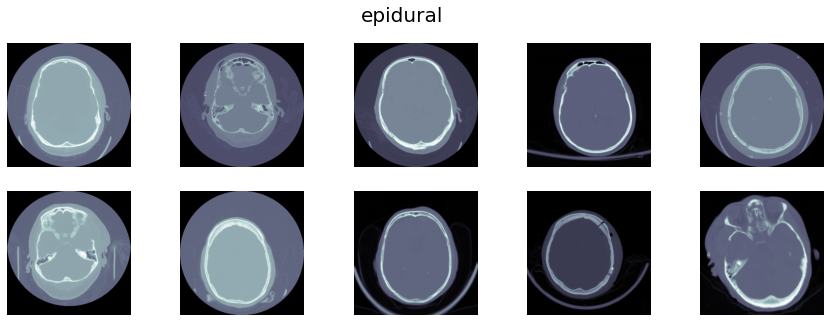

In [187]:
Visualize_Ten_Image(train_df, 'epidural')

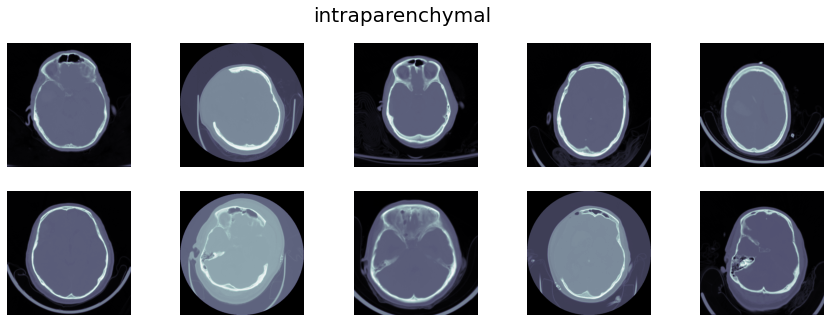

In [188]:
Visualize_Ten_Image(train_df, 'intraparenchymal')

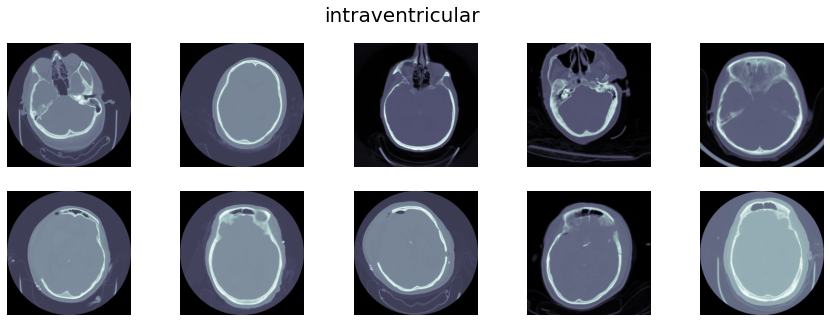

In [189]:
Visualize_Ten_Image(train_df, 'intraventricular')

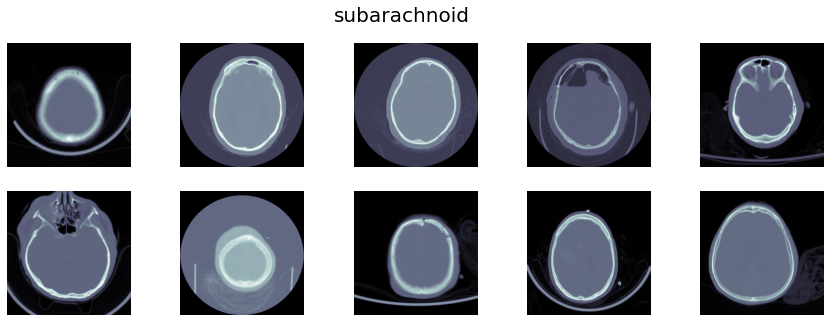

In [190]:
Visualize_Ten_Image(train_df, 'subarachnoid')

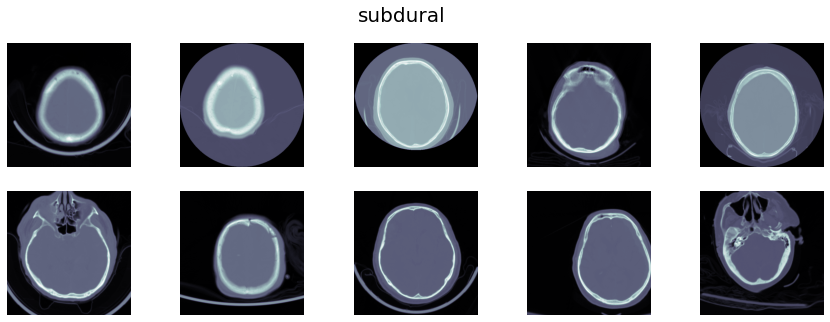

In [191]:
Visualize_Ten_Image(train_df, 'subdural')

## Read Images and windowing

many thanks to Ryan Epp. this code below was taken from Ryan Epp. if you want to check his kernel here is the link:: [Ryan Epp](https://www.kaggle.com/reppic/gradient-sigmoid-windowing)

In [192]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

def _read(path, SHAPE):
    dcm = pydicom.dcmread(path)
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(SHAPE)
    return img

## Create Data Generators

In [193]:
class Train_Val_Data_Generator(keras.utils.Sequence):
    
    def __init__(self, data, labels, batch_size = 32, img_size = (256, 256, 3), img_dir = train_image_dir, shuffle = False,*args, **kwargs):
        self.data = data
        self.ids = data.index
        self.labels = labels
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_generate(indices)
        return X, Y

    def on_epoch_end(self):
        
        self.indices = np.arange(len(self.ids))
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __data_generate(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
        for i, index in enumerate(indices):
            ID = self.ids[index]
            image = _read(str(self.img_dir)+str(ID)+".dcm", self.img_size)
            X[i,] = image
            Y[i,] = self.labels.iloc[index].values        
        return X, Y
    

class Test_Data_Generator(keras.utils.Sequence):
    
    def __init__(self, data, labels, batch_size = 32, img_size = (256, 256, 3), img_dir = test_image_dir, *args, **kwargs):
        self.data = data
        self.ids = data.index
        self.labels = labels
        self.img_size = img_size
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.on_epoch_end()
    
    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X= self.__data_generate(indices)
        return X

    def on_epoch_end(self):
        
        self.indices = np.arange(len(self.ids))
        
    
    def __data_generate(self, indices):
            X = np.empty((self.batch_size, *self.img_size))
            
            for i, index in enumerate(indices):
                ID = self.ids[index]
                image = _read(str(self.img_dir)+str(ID)+".dcm", self.img_size)
                X[i,] = image
                return X
    
    

In [194]:
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(train_df.index)
train_idx, valid_idx = next(ss)

In [195]:
train_gen = Train_Val_Data_Generator(train_df.iloc[train_idx], 
                                     train_df.iloc[train_idx],
                                     shuffle = True)
val_gen = Train_Val_Data_Generator(train_df.iloc[valid_idx], 
                                   train_df.iloc[valid_idx],
                                   shuffle = False)

test_gen = Test_Data_Generator(test_df, None,32, (256,256,3), test_image_dir,verbose =1)

In [196]:
inceptionv3 =tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)

## Create the Model

In [208]:
def build_model():
    print('Building Model..')
    model = Sequential()
    model.add(inceptionv3)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(6, activation='sigmoid'))
    
    model.compile(optimizer = keras.optimizers.Adam(), 
                  loss = 'binary_crossentropy',
                  metrics =  ['acc'])
    return model

model = build_model()
    
print(f'Model Summary: {model.summary()} ')


Building Model..
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 12294     
Total params: 21,815,078
Trainable params: 21,780,646
Non-trainable params: 34,432
_________________________________________________________________
Model Summary: None 


In [209]:
TRAIN_STEPS = int(len(train_gen) / 12)
model.fit_generator(generator = train_gen,
                    validation_data = val_gen,
                    steps_per_epoch = TRAIN_STEPS,
                    epochs = 1)

1764/1764 [==============================] - 1902s 1s/step - loss: 0.2085 - acc: 0.9885 - val_loss: 0.7253 - val_acc: 1.0000


In [210]:
test_steps = len(test_gen)
test_steps

3789

Many thanks to Robin Smits. The code below is taken from Robin Smits to submit Test predictions. if you want to check his kernel here is the link [Robin Smits](https://www.kaggle.com/rsmits/keras-efficientnet-b2-starter-code/notebook)

In [211]:
def predictions(test_df, model):    
    test_preds = model.predict_generator(test_gen, verbose = 1)
    return test_preds[:test_df.iloc[range(test_df.shape[0])].shape[0]]

In [212]:
submission_predictions =[]

In [213]:
preds = predictions(test_df, model)
submission_predictions.append(preds)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3789/3789 [==============================] - 224s 59ms/step


In [215]:
test_df.iloc[:, :] = np.average(submission_predictions, axis = 0, weights = [2**i for i in range(len(submission_predictions))])
test_df = test_df.stack().reset_index()
test_df.insert(loc = 0, column = 'ID', value = test_df['filename'].astype(str) + "_" + test_df['type'])
test_df = test_df.drop(["filename", "type"], axis=1)
test_df.to_csv('submission.csv', index = False)
print(test_df.head(12))

                               ID         Label
0                ID_000000e27_any  1.861139e-04
1           ID_000000e27_epidural  3.025344e-16
2   ID_000000e27_intraparenchymal  1.176090e-06
3   ID_000000e27_intraventricular  9.346066e-10
4       ID_000000e27_subarachnoid  6.408050e-07
5           ID_000000e27_subdural  6.888498e-07
6                ID_000009146_any  1.861138e-04
7           ID_000009146_epidural  3.025320e-16
8   ID_000009146_intraparenchymal  1.176090e-06
9   ID_000009146_intraventricular  9.346047e-10
10      ID_000009146_subarachnoid  6.408038e-07
11          ID_000009146_subdural  6.888511e-07
